# Trend Following Strategy

This notebook answers question 3.4 form the text book Advances in Financial Machine Learning.

3.4 Develop a trend-following strategy based on a popular technical analysis statistic (e.g., crossing moving averages). For each observation, the model suggests a side, but not a size of the bet.

* (a) Derive meta-labels for ptSl = [1, 2] and t1 where numDays = 1. Use as trgt the daily standard deviation as computed by Snippet 3.1.
* (b) Train a random forest to decide whether to trade or not. Note: The decision is whether to trade or not, {0,1}, since the underlying model (the crossing moving average) has decided the side, {-1, 1}.

I took some liberties by extending the features to which I use to build the meta model. I also add some performance metrics at the end. 

In conclusion: Meta Labeling works, SMA strategies suck.

In [1]:
import numpy as np
import pandas as pd
import pyfolio as pf
import timeit

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, classification_report, confusion_matrix, accuracy_score
from sklearn.utils import resample
from sklearn.utils import shuffle

from mlfinlab.corefns.core_functions import CoreFunctions
from mlfinlab.util.utils import get_daily_returns
from mlfinlab.fracdiff.fracdiff import frac_diff_ffd

import matplotlib.pyplot as plt
%matplotlib inline

### Read in Data
We are using the dollar bars based off of the high quality HFT data we purchased. There is a sample of bars available in this branch as well. 

In [2]:
# Read in data
data = pd.read_csv('official_data/dollar_bars.csv')
data.index = pd.to_datetime(data['date_time'])
data = data.drop('date_time', axis=1)

In [3]:
data = data['2011-09-01':]

---
### Fit a Primary Model: Trend Following
Based on the simple moving average cross-over strategy.


In [4]:
fast_window = 20
slow_window = 50

data['fast_mavg'] = data['close'].rolling(window=fast_window, min_periods=fast_window, center=False).mean()
data['slow_mavg'] = data['close'].rolling(window=slow_window, min_periods=slow_window, center=False).mean()
data.head()

# Compute sides
data['side'] = np.nan

long_signals = data['fast_mavg'] >= data['slow_mavg']
short_signals = data['fast_mavg'] < data['slow_mavg']
data.loc[long_signals, 'side'] = 1
data.loc[short_signals, 'side'] = -1

# Remove Look ahead biase by lagging the signal
data['side'] = data['side'].shift(1)

In [5]:
# Save the raw data
raw_data = data.copy()

# Drop the NaN values from our data set
data.dropna(axis=0, how='any', inplace=True)

In [6]:
data['side'].value_counts()

 1.0    45136
-1.0    38762
Name: side, dtype: int64

### Filter Events: CUSUM Filter
Predict what will happen when a CUSUM event is triggered. Use the signal from the MAvg Strategy to determine the side of the bet.

In [7]:
# Compute daily volatility
daily_vol = CoreFunctions.get_daily_vol(close=data['close'], lookback=50)

# Apply Symmetric CUSUM Filter and get timestamps for events
# Note: Only the CUSUM filter needs a point estimate for volatility
cusum_events = CoreFunctions.get_t_events(data['close'], threshold=daily_vol.mean()*0.5)

# Compute vertical barrier
vertical_barriers = CoreFunctions.add_vertical_barrier(t_events=cusum_events, close=data['close'], num_days=1)

  0%|          | 0/83896 [00:00<?, ?it/s]

Calculating daily volatility for dynamic thresholds
Applying Symmetric CUSUM filter.


100%|██████████| 83896/83896 [00:15<00:00, 5247.82it/s]


In [8]:
pt_sl = [1, 2]
min_ret = 0.005
triple_barrier_events = CoreFunctions.get_events(close=data['close'],
                                  t_events=cusum_events,
                                  pt_sl=pt_sl,
                                  target=daily_vol,
                                  min_ret=min_ret,
                                  num_threads=2,
                                  vertical_barrier_times=vertical_barriers,
                                  side=data['side'])

/home/ariadne/Desktop/Research Project/research/Chapter3/mlfinlab/corefns/core_functions.py:205: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  target = target.loc[t_events]
2019-03-17 01:12:29.984750 100.0% apply_pt_sl_on_t1 done after 0.33 minutes. Remaining 0.0 minutes.


In [9]:
labels = CoreFunctions.get_bins(triple_barrier_events, data['close'])
labels.side.value_counts()

-1.0    4287
 1.0    3919
Name: side, dtype: int64

---
### Results of Primary Model:
What is the accuracy of predictions from the primary model (i.e., if the sec- ondary model does not filter the bets)? What are the precision, recall, and F1-scores?

In [10]:
primary_forecast = pd.DataFrame(labels['bin'])
primary_forecast['pred'] = 1
primary_forecast.columns = ['actual', 'pred']

# Performance Metrics
actual = primary_forecast['actual']
pred = primary_forecast['pred']
print(classification_report(y_true=actual, y_pred=pred))

print("Confusion Matrix")
print(confusion_matrix(actual, pred))

print('')
print("Accuracy")
print(accuracy_score(actual, pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      4828
           1       0.41      1.00      0.58      3378

   micro avg       0.41      0.41      0.41      8206
   macro avg       0.21      0.50      0.29      8206
weighted avg       0.17      0.41      0.24      8206

Confusion Matrix
[[   0 4828]
 [   0 3378]]

Accuracy
0.4116500121862052


/home/ariadne/anaconda3/envs/mlfinlab/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
## Fit a Meta Model
Train a random forest to decide whether to trade or not (i.e 1 or 0 respectively) since the earlier model has decided the side (-1 or 1)

Create the following features: 
* Volatility
* Serial Correlation
* The returns at the different lags from the serial correlation
* The sides from the SMavg Strategy

In [11]:
raw_data.head()

,open,high,low,close,cum_vol,cum_dollar,cum_ticks,fast_mavg,slow_mavg,side
date_time,,,,,,,,,,
2011-09-01 06:08:14.750,1217.50,1224.50,1216.5,1220.00,57388,70028257.0,19018,NaN,NaN,NaN
2011-09-01 07:48:09.398,1220.00,1224.50,1215.5,1215.75,57394,70005670.5,20160,NaN,NaN,NaN
2011-09-01 09:13:14.311,1215.75,1216.50,1209.5,1210.00,57691,70000560.5,21107,NaN,NaN,NaN
2011-09-01 10:51:49.085,1210.00,1213.50,1208.5,1212.50,57801,70003237.5,17728,NaN,NaN,NaN
2011-09-01 12:23:59.756,1212.50,1216.75,1210.5,1215.75,57656,70000722.0,19398,NaN,NaN,NaN


### Features

In [12]:
# Log Returns
raw_data['log_ret'] = np.log(raw_data['close']).diff()

# Momentum
raw_data['mom1'] = raw_data['close'].pct_change(periods=1)
raw_data['mom2'] = raw_data['close'].pct_change(periods=2)
raw_data['mom3'] = raw_data['close'].pct_change(periods=3)
raw_data['mom4'] = raw_data['close'].pct_change(periods=4)
raw_data['mom5'] = raw_data['close'].pct_change(periods=5)

# Volatility
raw_data['volatility_50'] = raw_data['log_ret'].rolling(window=50, min_periods=50, center=False).std()
raw_data['volatility_31'] = raw_data['log_ret'].rolling(window=31, min_periods=31, center=False).std()
raw_data['volatility_15'] = raw_data['log_ret'].rolling(window=15, min_periods=15, center=False).std()

# Serial Correlation (Takes about 4 minutes)
window_autocorr = 50

raw_data['autocorr_1'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=1), raw=False)
raw_data['autocorr_2'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=2), raw=False)
raw_data['autocorr_3'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=3), raw=False)
raw_data['autocorr_4'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=4), raw=False)
raw_data['autocorr_5'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=5), raw=False)

# Get the various log -t returns
raw_data['log_t1'] = raw_data['log_ret'].shift(1)
raw_data['log_t2'] = raw_data['log_ret'].shift(2)
raw_data['log_t3'] = raw_data['log_ret'].shift(3)
raw_data['log_t4'] = raw_data['log_ret'].shift(4)
raw_data['log_t5'] = raw_data['log_ret'].shift(5)

In [13]:
# Re compute sides
raw_data['side'] = np.nan

long_signals = raw_data['fast_mavg'] >= raw_data['slow_mavg']
short_signals = raw_data['fast_mavg'] < raw_data['slow_mavg']
raw_data.loc[long_signals, 'side'] = 1
raw_data.loc[short_signals, 'side'] = -1

In [14]:
# Remove look ahead bias
raw_data = raw_data.shift(1)

#### Now get the data at the specified events

In [15]:
# Get features at event dates
X = raw_data.loc[labels.index, :]

# Drop unwanted columns
X.drop(['open', 'high', 'low', 'close', 'cum_vol', 'cum_dollar', 'cum_ticks','fast_mavg', 'slow_mavg',], axis=1, inplace=True)

y = labels['bin']

In [16]:
y.value_counts()

0    4828
1    3378
Name: bin, dtype: int64

### Balance classes

In [17]:
# Split data into training, validation and test sets
X_training_validation = X['2011-09-01':'2018-01-01']
y_training_validation = y['2011-09-01':'2018-01-01']
X_train, X_validate, y_train, y_validate = train_test_split(X_training_validation, y_training_validation, test_size=0.15, shuffle=False)

In [18]:
train_df = pd.concat([y_train, X_train], axis=1, join='inner')
train_df['bin'].value_counts()

0    3186
1    2042
Name: bin, dtype: int64

In [19]:
# Upsample the training data to have a 50 - 50 split
# https://elitedatascience.com/imbalanced-classes
majority = train_df[train_df['bin'] == 0]
minority = train_df[train_df['bin'] == 1]

new_minority = resample(minority, 
                   replace=True,     # sample with replacement
                   n_samples=majority.shape[0],    # to match majority class
                   random_state=42)

train_df = pd.concat([majority, new_minority])
train_df = shuffle(train_df, random_state=42)

train_df['bin'].value_counts()

1    3186
0    3186
Name: bin, dtype: int64

In [20]:
# Create training data
y_train = train_df['bin']
X_train= train_df.loc[:, train_df.columns != 'bin']

### Fit a model

In [21]:
from sklearn.model_selection import cross_val_score

In [22]:
from sklearn.model_selection import GridSearchCV

In [23]:
parameters = {'max_depth':[2, 3, 4, 5, 7],
              'n_estimators':[1, 10, 25, 50, 100, 256, 512],
              'random_state':[42]}

In [24]:
rf = RandomForestClassifier(criterion='entropy')


In [25]:
clf = GridSearchCV(rf, parameters, cv=4, scoring='roc_auc', n_jobs=3)

In [26]:
clf.fit(X_train, y_train)

GridSearchCV(cv=4, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=3,
       param_grid={'max_depth': [2, 3, 4, 5, 7], 'n_estimators': [1, 10, 25, 50, 100, 256, 512], 'random_state': [42]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [27]:
clf.cv_results_['mean_test_score']

array([0.53693618, 0.58613349, 0.59141314, 0.59475192, 0.59982534,
       0.60086751, 0.60031512, 0.55131481, 0.60031747, 0.60767063,
       0.61275975, 0.614586  , 0.61567003, 0.61469273, 0.55738571,
       0.62083821, 0.63018054, 0.63315974, 0.63524615, 0.63544491,
       0.63545723, 0.56830318, 0.63726233, 0.65334062, 0.65828394,
       0.66083581, 0.66315266, 0.66300544, 0.57523613, 0.69119345,
       0.71772208, 0.73060621, 0.73351347, 0.73717298, 0.73638619])

In [28]:
# Random Forest Model
n_estimator = clf.best_params_['n_estimators']
c_random_state = 42
depth = clf.best_params_['max_depth']

rf = RandomForestClassifier(max_depth=depth, n_estimators=n_estimator,
                            criterion='entropy', random_state=c_random_state)

rf.fit(X_train, y_train.values.ravel())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=7, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=256, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

#### Training Metrics

              precision    recall  f1-score   support

           0       0.78      0.79      0.79      3186
           1       0.79      0.78      0.79      3186

   micro avg       0.79      0.79      0.79      6372
   macro avg       0.79      0.79      0.79      6372
weighted avg       0.79      0.79      0.79      6372

Confusion Matrix
[[2523  663]
 [ 694 2492]]

Accuracy
0.7870370370370371


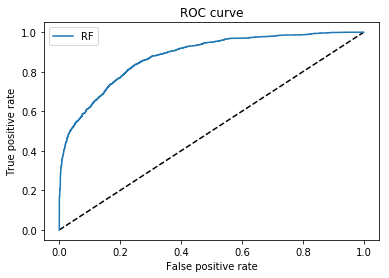

In [29]:
# Performance Metrics
y_pred_rf = clf.predict_proba(X_train)[:, 1]
y_pred = clf.predict(X_train)
fpr_rf, tpr_rf, _ = roc_curve(y_train, y_pred_rf)
print(classification_report(y_train, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_train, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_train, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

#### Validation Metrics

              precision    recall  f1-score   support

           0       0.68      0.63      0.65       582
           1       0.44      0.49      0.46       341

   micro avg       0.58      0.58      0.58       923
   macro avg       0.56      0.56      0.56       923
weighted avg       0.59      0.58      0.58       923

Confusion Matrix
[[367 215]
 [173 168]]

Accuracy
0.5796316359696642


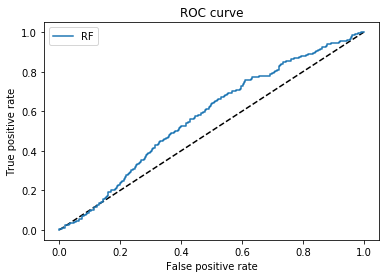

In [30]:
# Performance Metrics
y_pred_rf = clf.predict_proba(X_validate)[:, 1]
y_pred = clf.predict(X_validate)
fpr_rf, tpr_rf, _ = roc_curve(y_validate, y_pred_rf)
print(classification_report(y_validate, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_validate, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_validate, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

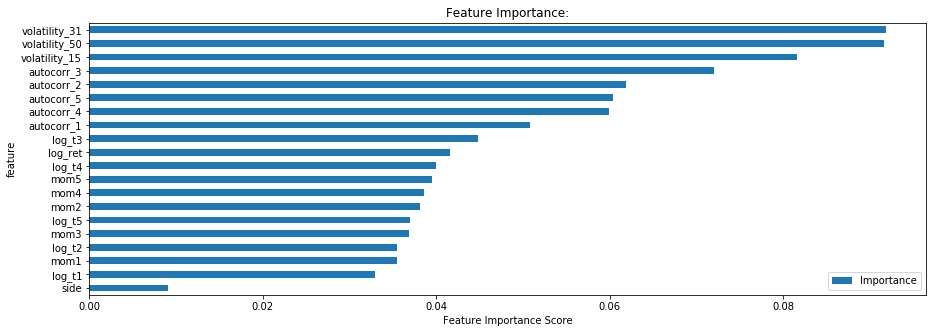

In [31]:
# Feature Importance
title = 'Feature Importance:'
figsize = (15, 5)

feat_imp = pd.DataFrame({'Importance':rf.feature_importances_})    
feat_imp['feature'] = X.columns
feat_imp.sort_values(by='Importance', ascending=False, inplace=True)
feat_imp = feat_imp

feat_imp.sort_values(by='Importance', inplace=True)
feat_imp = feat_imp.set_index('feature', drop=True)
feat_imp.plot.barh(title=title, figsize=figsize)
plt.xlabel('Feature Importance Score')
plt.show()

---
## Performance Tear Sheets (In-sample)

### Without Meta Labeling

In [32]:
valid_dates = X_validate.index
base_rets = labels.loc[valid_dates, 'ret']
primary_model_rets = get_daily_returns(base_rets)

In [33]:
# Set-up the function to extract the KPIs from pyfolio
perf_func = pf.timeseries.perf_stats

In [34]:
# Save the statistics in a dataframe
perf_stats_all = perf_func(returns=primary_model_rets, 
                           factor_returns=None, 
                           positions=None,
                           transactions=None,
                           turnover_denom="AGB")
perf_stats_df = pd.DataFrame(data=perf_stats_all, columns=['Primary Model'])

pf.show_perf_stats(primary_model_rets)

Start date,2016-01-21
End date,2017-12-04
Total months,23
,Backtest
Annual return,-15.8%
Cumulative returns,-28.3%
Annual volatility,59.1%
Sharpe ratio,-0.01
Calmar ratio,-0.27
Stability,0.75
Max drawdown,-59.5%


### With Meta Labeling

In [35]:
meta_returns = labels.loc[valid_dates, 'ret'] * y_pred
daily_meta_rets = get_daily_returns(meta_returns)

In [36]:
# Save the KPIs in a dataframe
perf_stats_all = perf_func(returns=daily_meta_rets, 
                           factor_returns=None, 
                           positions=None,
                           transactions=None,
                           turnover_denom="AGB")

perf_stats_df['Meta Model'] = perf_stats_all

pf.show_perf_stats(daily_meta_rets)

/home/ariadne/anaconda3/envs/mlfinlab/lib/python3.6/site-packages/empyrical/stats.py:1511: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))


Start date,2016-01-21
End date,2017-12-04
Total months,23
,Backtest
Annual return,-2.1%
Cumulative returns,-4.0%
Annual volatility,51.8%
Sharpe ratio,0.23
Calmar ratio,-0.04
Stability,0.63
Max drawdown,-47.5%


---
## Perform out-of-sample test
### Meta Model Metrics

In [37]:
# Extarct data for out-of-sample (OOS)
X_oos = X['2018-01-02':]
y_oos = y['2018-01-02':]

              precision    recall  f1-score   support

           0       0.55      0.64      0.59      1060
           1       0.53      0.44      0.48       995

   micro avg       0.54      0.54      0.54      2055
   macro avg       0.54      0.54      0.53      2055
weighted avg       0.54      0.54      0.54      2055

Confusion Matrix
[[680 380]
 [562 433]]

Accuracy
0.5416058394160584


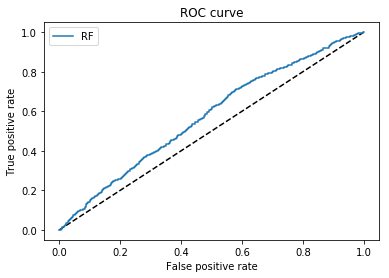

In [38]:
# Performance Metrics
y_pred_rf = clf.predict_proba(X_oos)[:, 1]
y_pred = clf.predict(X_oos)
fpr_rf, tpr_rf, _ = roc_curve(y_oos, y_pred_rf)
print(classification_report(y_oos, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_oos, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_oos, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

## Primary Model (Test Data)

Start date,2018-01-18
End date,2019-01-31
Total months,12
,Backtest
Annual return,340.3%
Cumulative returns,392.3%
Annual volatility,119.4%
Sharpe ratio,1.73
Calmar ratio,5.65
Stability,0.02
Max drawdown,-60.3%


Start date,2018-01-18
End date,2019-01-31
Total months,12
,Backtest
Annual return,340.3%
Cumulative returns,392.3%
Annual volatility,119.4%
Sharpe ratio,1.73
Calmar ratio,5.65
Stability,0.02
Max drawdown,-60.3%


/home/ariadne/anaconda3/envs/mlfinlab/lib/python3.6/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,60.26,2018-04-30,2018-11-13,2018-12-20,169
1,24.98,2018-12-24,2019-01-02,2019-01-30,28
2,21.78,2018-03-05,2018-04-05,2018-04-19,34
3,9.24,2018-12-20,2018-12-21,2018-12-24,3
4,8.89,2018-02-06,2018-02-07,2018-02-08,3


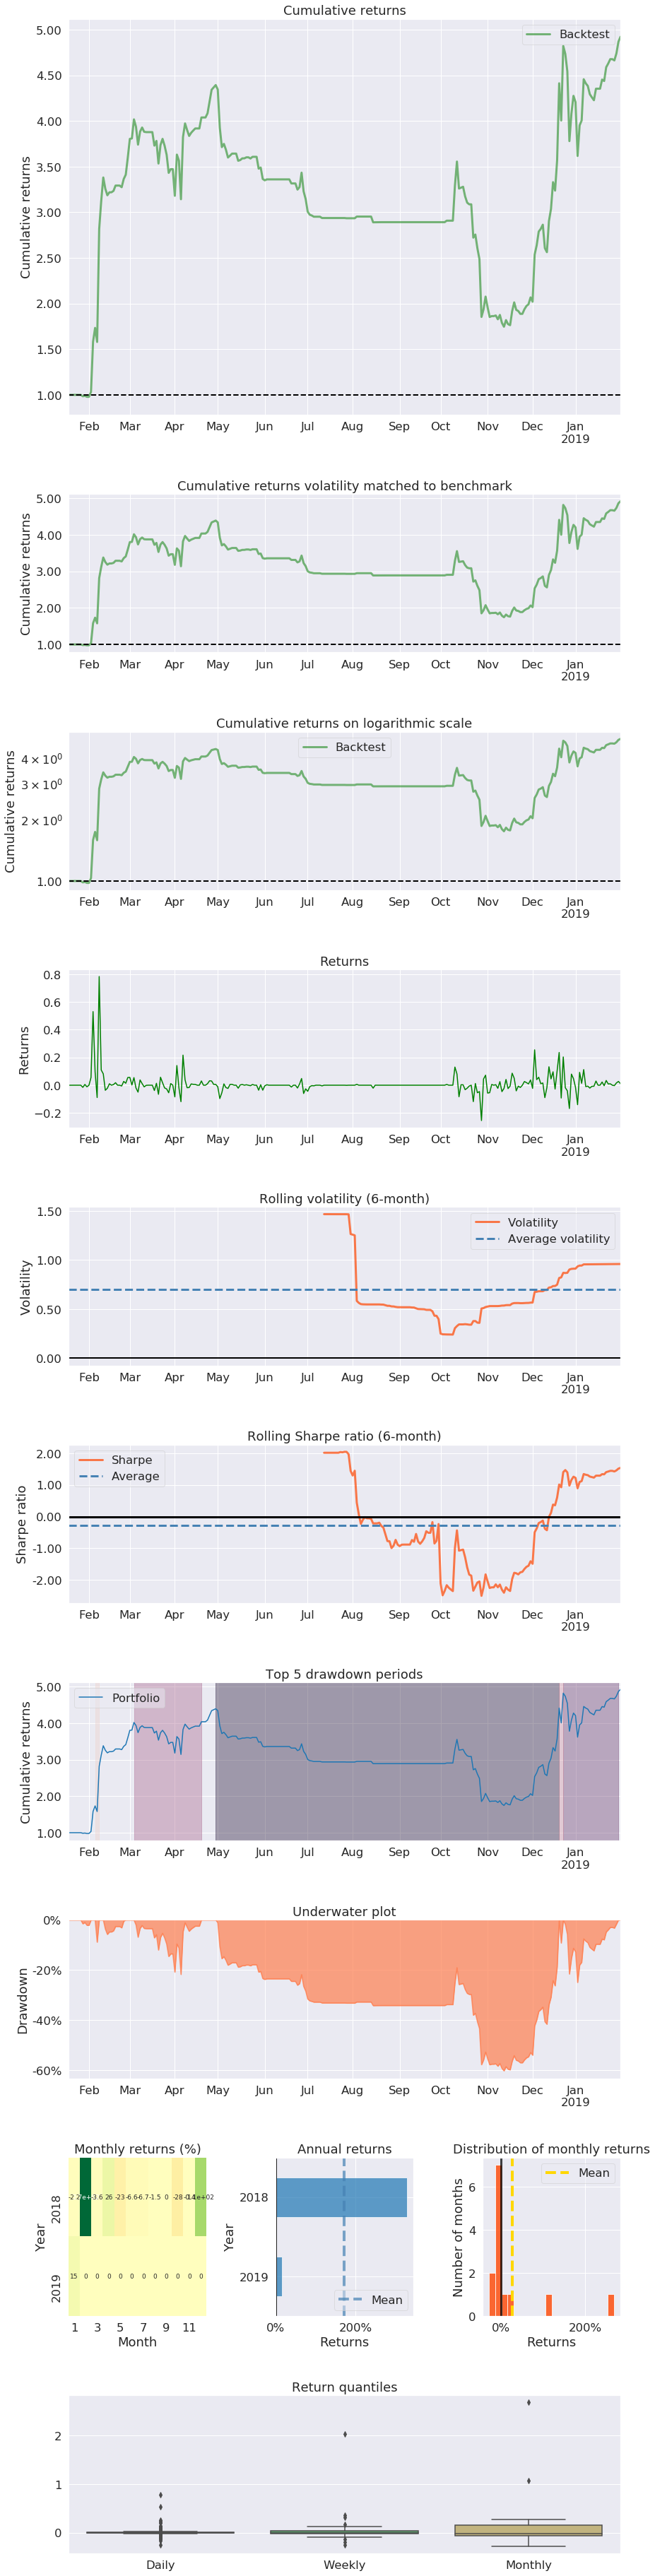

In [39]:
test_dates = X_oos.index

# Downsample to daily
prim_rets_test = labels.loc[test_dates, 'ret']
daily_rets_prim = get_daily_returns(prim_rets_test)

# Save the statistics in a dataframe
perf_stats_all = perf_func(returns=daily_rets_prim, 
                           factor_returns=None, 
                           positions=None,
                           transactions=None,
                           turnover_denom="AGB")

perf_stats_df['Primary Model OOS'] = perf_stats_all

# pf.create_returns_tear_sheet(labels.loc[test_dates, 'ret'], benchmark_rets=None)
pf.show_perf_stats(daily_rets_prim)

pf.create_returns_tear_sheet(daily_rets_prim, benchmark_rets=None)

## Meta Model (Test Data)

Start date,2018-01-18
End date,2019-01-31
Total months,12
,Backtest
Annual return,113.6%
Cumulative returns,126.2%
Annual volatility,75.2%
Sharpe ratio,1.33
Calmar ratio,4.16
Stability,0.07
Max drawdown,-27.3%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,27.34,2018-04-24,2018-12-11,2018-12-20,173
1,25.86,2018-12-24,2019-01-29,NaT,NaN
2,15.34,2018-03-01,2018-04-05,2018-04-06,27
3,5.90,2018-02-08,2018-02-14,2018-03-01,16
4,0.78,2018-04-12,2018-04-13,2018-04-24,9


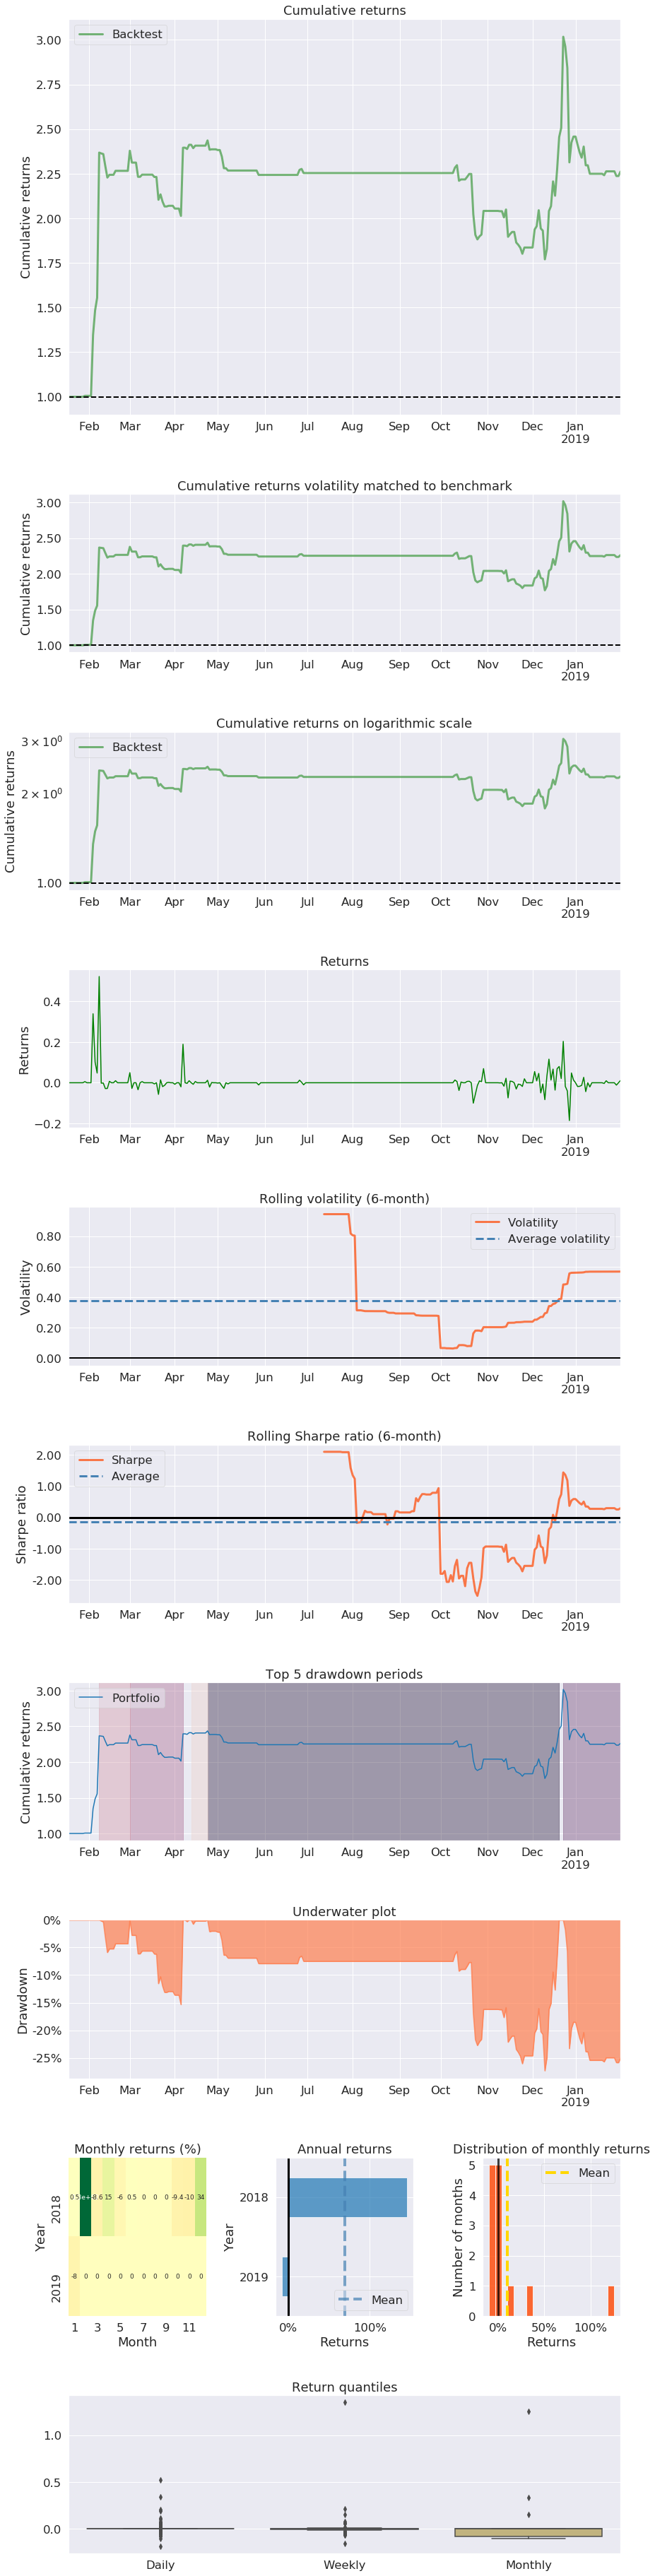

In [40]:
meta_returns = labels.loc[test_dates, 'ret'] * y_pred
daily_rets_meta = get_daily_returns(meta_returns)

# save the KPIs in a dataframe
perf_stats_all = perf_func(returns=daily_rets_meta, 
                           factor_returns=None, 
                           positions=None,
                           transactions=None,
                           turnover_denom="AGB")

perf_stats_df['Meta Model OOS'] = perf_stats_all

pf.create_returns_tear_sheet(daily_rets_meta, benchmark_rets=None)